# Outline of correction and velocity calculations from SDO/HMI Images

In [12]:
import datetime
import pandas as pd
import numpy as np

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import sys, os

sys.path.append(os.path.realpath('../../'))

import SolAster.tools.rvs as rvs
import SolAster.tools.calculation_funcs as sfuncs
import SolAster.tools.lbc_funcs as lbfuncs
import SolAster.tools.coord_funcs as ctfuncs
import SolAster.tools.utilities as utils
from SolAster.tools.settings import *
from SolAster.tools.plotting_funcs import hmi_plot

In [13]:
# update inputs class
class Inputs:
    """
    Class to hold user specified inputs to run examples.
    See README or documentation site for additional information.
    """

    # name of csv file to store calculations
    csv_name = 'example_calcs.csv'

    # name of instrument to use for calculation of RV model
    # choose either 'NEID' or 'HARPS-N'
    inst = 'NEID'

    # querying cadence in seconds
    cadence = 24 * 60 * 60

    # start date for calculationsx
    start_date = datetime.datetime(2021, 2, 10, 0, 0, 0)

    # end date for calculations
    end_date = datetime.datetime(2021, 2, 14, 0, 0, 0)

    # True if outputting diagnostic plots
    diagnostic_plots = True
    # path to save diagnostic figure or none
    save_fig = None
    
    # figure title for plot of calculations
    fig_title = 'example_plot.png'


Setup CSV file and SDO/HMI querying parameters.

In [ ]:
# check input formats
start_date, end_date, cadence, csv_name = utils.check_inputs(CsvDir.CALC,  Inputs.start_date,  Inputs.end_date,
                                                             Inputs.cadence,  Inputs.csv_name)


# print out csv title
print("Beginning calculation of values for csv file: " + csv_name)

# List of header strings
row_contents = ['date_obs', 'date_jd', 'rv_model', 'v_quiet', 'v_disc', 'v_phot', 'v_conv', 'f_bright', 'f_spot', 'f',
                'Bobs', 'vphot_bright', 'vphot_spot', 'f_small', 'f_large', 'f_network', 'f_plage',
                'quiet_flux', 'ar_flux', 'conv_flux', 'pol_flux', 'pol_conv_flux', 'vconv_quiet', 'vconv_large',
                'vconv_small']

# create file names
csv_file = os.path.join(CsvDir.CALC, csv_name)
bad_dates_csv = os.path.join(CsvDir.CALC, csv_name[:-4]+'_bad_dates.csv')
print(bad_dates_csv)
utils.append_list_as_row(csv_file, row_contents)


# get hmi data products
time_range = datetime.timedelta(seconds=22)
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

# get dates list
xy = (end_date - start_date).seconds + (end_date - start_date).days * 24 * 3600
dates_list = [start_date + datetime.timedelta(seconds=cadence*x) for x in range(0, int(xy/cadence))]

## Component calculations
Run through list to calculate and save values.

In [ ]:
for i, date in enumerate(dates_list):
    # convert the date to a string -- required for use in csv file
    date_str, date_obj, date_jd = utils.get_dates(date)

    # pull image within specified time range
    result = Fido.search(a.Time(str(date_obj - time_range), str(date_obj + time_range)),
                         a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2])

    # add file to list
    file_download = Fido.fetch(result)

    # remove unusable file types
    good_files = []
    for file in file_download:
        name, extension = os.path.splitext(file)
        if extension == '.fits':
            good_files.append(file)

    if len(good_files) != 3:
        # add the data
        # append these values to the csv file
        save_vals = [date_str, 'not three good files']
        # print that the files are missing
        print('\nNot three good files: ' + date_str + ' index: ' + str(i))

        pass
    else:
        # convert to map sequence
        map_seq = sunpy.map.Map(sorted(good_files))

        # check for missing data types
        missing_map = False
        # split into data types
        for j, map_obj in enumerate(map_seq):
            if map_obj.meta['content'] == 'DOPPLERGRAM':
                vmap = map_obj
            elif map_obj.meta['content'] == 'MAGNETOGRAM':
                mmap = map_obj
            elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
                imap = map_obj
            else:
                missing_map = True

        if missing_map:
            print("Missing a data product for " + date_str)

            # add the data
            # append these values to the csv file
            save_vals = [date_str, 'missing data product']
            pass

        else:
            # coordinate transformation for maps
            x, y, pdim, r, d, mu = ctfuncs.coordinates(vmap)
            wij, nij, rij = ctfuncs.vel_coords(x, y, pdim, r, vmap)

            # remove bad mu values
            vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap], mu_cutoff=Parameters.mu_cutoff)

            # calculate relative positions
            deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

            # calculate spacecraft velocity
            vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

            # optimized solar rotation parameters
            a_parameters = [Parameters.a1, Parameters.a2, Parameters.a3]

            # calculation of solar rotation velocity
            vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

            # calculate corrected velocity
            corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

            # corrected velocity maps
            map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                               frame=frames.HeliographicCarrington)

            # limb brightening
            Lij = lbfuncs.limb_polynomial(imap)

            # calculate corrected data
            Iflat = imap.data / Lij

            # corrected intensity maps
            map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                               frame=frames.HeliographicCarrington)

            # calculate unsigned field strength
            Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise=Parameters.B_noise, mu_cutoff=Parameters.mu_cutoff)

            # corrected observed magnetic data map
            map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

            # radial magnetic data map
            map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

            # calculate magnetic threshold
            active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

            # calculate intensity threshold
            fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

            # create threshold array
            thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

            # full threshold maps
            map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                                   frame=frames.HeliographicCarrington)

            # create diagnostic plots
            if i == 0 and Inputs.diagnostic_plots == True:
                    hmi_plot(map_int_cor, map_mag_cor, map_vel_cor, fac_inds, spot_inds, mu, save_fig=Inputs.save_fig)

            ### velocity contribution due to convective motion of quiet-Sun
            v_quiet = sfuncs.v_quiet(map_vel_cor, imap, quiet)

            ### velocity contribution due to rotational Doppler imbalance of active regions (faculae/sunspots)
            # calculate photospheric velocity
            v_phot, vphot_bright, vphot_spot = sfuncs.v_phot(quiet, active, Lij, vrot, imap, mu, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

            ### velocity contribution due to suppression of convective blueshift by active regions
            # calculate disc-averaged velocity
            v_disc = sfuncs.v_disc(map_vel_cor, imap)

            # calculate convective velocity
            v_conv = v_disc - v_quiet

            ### filling factor
            # calculate filling factor
            f_bright, f_spot, f = sfuncs.filling_factor(mu, mmap, active, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

            ### unsigned magnetic flux
            # unsigned observed flux
            unsigned_obs_flux = sfuncs.unsigned_flux(map_mag_obs, imap)

            ### calculate the area filling factor
            pixA_hem = ctfuncs.pix_area_hem(wij, nij, rij, vmap)
            area = sfuncs.area_calc(active, pixA_hem)
            f_small, f_large, f_network, f_plage = sfuncs.area_filling_factor(active, area, mu, mmap, fac_inds,
                                                                              athresh=Parameters.athresh,
                                                                              mu_cutoff=Parameters.mu_cutoff)

            ### get the unsigned flux
            quiet_flux, ar_flux, conv_flux, pol_flux, pol_conv_flux = sfuncs.area_unsigned_flux(map_mag_obs, imap,
                                                                                                    area,
                                                                                                    active,
                                                                                                athresh=Parameters.athresh)

            ### get area weighted convective velocities
            vconv_quiet, vconv_large, vconv_small = sfuncs.area_vconv(map_vel_cor, imap, active, area, athresh=Parameters.athresh)
            ### calculate model RV
            rv_model = rvs.calc_model(Inputs.inst, v_conv, v_phot)

            # intensity flux to check
            int_flux = np.nansum(imap.data)
            
            # make array of what we want to save
            save_vals = [rv_model, v_quiet, v_disc, v_phot, v_conv, f_bright, f_spot, f, unsigned_obs_flux, vphot_bright,
                         vphot_spot, f_small, f_large, f_network, f_plage, quiet_flux, ar_flux,
                         conv_flux, pol_flux, pol_conv_flux, vconv_quiet, vconv_large, vconv_small, int_flux]

            # round stuff
            rounded = np.around(save_vals, 3)
            round_vals = [date_str, date_jd]
            for val in rounded:
                round_vals.append(val)

            # append these values to the csv file
            utils.append_list_as_row(csv_file, round_vals)

            # print that the date is completed
            print('\nCalculations and save to file complete for ' + date_str + ' index: ' + str(i))

print('Calculation complete for dates:', start_date, 'to', end_date)

# Plotting results

In [15]:
# csv file with rv components
csv_file = os.path.join(CsvDir.CALC, Inputs.csv_name)

# create pandas dataframe
component_df = pd.read_csv(csv_file)

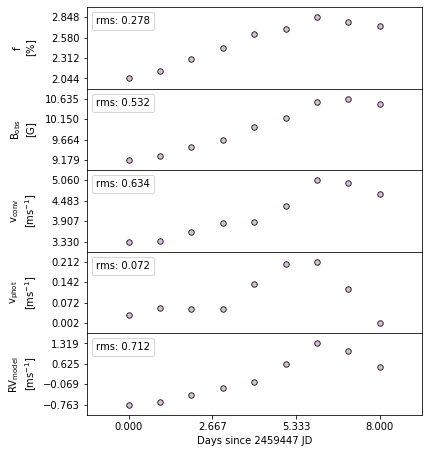

In [16]:
import matplotlib.pyplot as plt

# date to plot
date_jd = component_df.date_jd.values
x = date_jd - date_jd[0]
y_list = [component_df.f.values, component_df.Bobs.values, component_df.v_conv.values, component_df.v_phot.values,
          component_df.rv_model.values - np.median(component_df.rv_model.values)]

# plot labels
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm f$' '\n' r'$\rm$[%]',
               r'$\rm B_{\rm obs}$' '\n' r'$\rm [G]$',
               r'$\rm v_{\rm conv}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm v_{\rm phot}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm model}$' '\n' r'$\rm[m s^{-1}]$']

# set up figure
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[6, 1.5 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
    rng = (y_list[i].max() - y_list[i].min())
    step = rng/6
    ylim = (y_list[i].min() - step, y_list[i].max() + step)
    yticks = np.arange(y_list[i].min(), y_list[i].max()+0.0002, step=step*2)
    axs[i].set(ylim=ylim, yticks=yticks)

# create x-axis ticks and labels
axs[i].set(xlabel=xlabel)
rng = (x.max() - x.min())
step = rng/6
xlim = (x.min() - step, x.max() + step)
xticks = np.arange(x.min(), x.max()+.001, step=step*2)
axs[i].set(xlim=xlim, xticks=xticks)

# plot data
for i in range(0, len(axs)):
    axs[i].scatter(x, y_list[i], color='thistle', s=30, edgecolors='k', linewidths=0.8,
                   label='rms: ' + str(np.round(np.std(y_list[i]), 3)))

    leg = axs[i].legend(handlelength=0, handletextpad=0, loc='upper left')
    for item in leg.legendHandles:
        item.set_visible(False)


# align y axis labels
fig.align_ylabels(axs)

# save figure
fig_path = os.path.join(ImgDir.IMG_DIR, Inputs.fig_title)
fig.savefig(fig_path, dpi=1200)


